# Connect Eye-AI and Load Libraries

In [1]:
%load_ext autoreload
%autoreload 2

# # Update the load path so python can find modules for the model
import sys
from pathlib import Path
sys.path.insert(0, str(Path.home() / "eye-ai-ml"))
sys.path.insert(0, str(Path.home() / "eye-ai-exec"))

In [2]:
# Prerequisites
import json
import os

# EyeAI, Deriva, VGG19
from deriva_ml import DatasetSpec, DatasetBag, Workflow, ExecutionConfiguration, VersionPart
from deriva_ml import MLVocab as vc
from eye_ai.eye_ai import EyeAI
from models.vgg19 import vgg19_diagnosis_train

# ML Analytics
import pandas as pd
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Other Utilities
from pathlib import Path, PurePath
import logging
from datetime import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

2025-06-18 15:15:02.601623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-18 15:15:02.601674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-18 15:15:02.602411: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-18 15:15:02.608166: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-18 15:15:03.392760: W tensorflow/compiler/tf2

In [3]:
# Login
from deriva.core.utils.globus_auth_utils import GlobusNativeLogin
host = 'www.eye-ai.org'
#host = 'dev.eye-ai.org' #for dev testing
catalog_id = "eye-ai"

gnl = GlobusNativeLogin(host=host)
if gnl.is_logged_in([host]):
    print("You are already logged in.")
else:
    gnl.login([host], no_local_server=True, no_browser=True, refresh_tokens=True, update_bdbag_keychain=True)
    print("Login Successful")

2025-06-18 15:15:04,031 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-18 15:15:04,032 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


You are already logged in.


# Configuration

In [4]:
cache_dir = '/data'
working_dir = '/data'
EA = EyeAI(hostname = host, catalog_id = catalog_id, cache_dir= cache_dir, working_dir=working_dir)

2025-06-18 15:15:05,780 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-18 15:15:05,780 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


In [5]:

#EA.increment_dataset_version(dataset_rid='4-YWKJ', component= VersionPart.patch, description='Update after annotations added')

In [6]:
source_dataset = "4-YWKJ" # USC test set

# asset_RID = ["4-MWQ6"]  # VGG19 cropped
# crop = True

asset_RID = ["4-MWQ8"]  # VGG19 uncropped
crop = False

preds_workflow = EA.add_workflow( 
    Workflow(
        name="VGG Predictions by KB",
        url="https://github.com/informatics-isi-edu/eye-ai-exec/blob/main/notebooks/Sandbox_KB/VGG_Predict.ipynb",
        workflow_type="Test Workflow",
        )
    )

config = ExecutionConfiguration(
    datasets=[ DatasetSpec(rid=source_dataset, version=EA.dataset_version(source_dataset), materialize=True) ],
    assets=asset_RID,
    workflow=preds_workflow,
    description="Instance of creating VGG19 predictions: VGG19 Uncropped on 4-YWKJ USC Test",
    )

execution = EA.create_execution(config)

2025-06-18 15:15:08,350 - INFO - Materialize bag 4-YWKJ... 
2025-06-18 15:15:08,461 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-06-18 15:15:08,462 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-06-18 15:15:09,904 - INFO - Using cached bag for  4-YWKJ Version:0.2.0
2025-06-18 15:15:09,904 - INFO - Loading /data/4-YWKJ_44b67c208c639554dd582f1575a7466fd853affad87411a7f99d28c7559acbbb/Dataset_4-YWKJ
2025-06-18 15:15:10,347 - INFO - Creating new database for dataset: 4-YWKJ in /data/kb_766/EyeAI_working/4-YWKJ@33F-J5QX-5CCA.db
2025-06-18 15:15:10,393 - INFO - Downloading assets ...
2025-06-18 15:15:30,428 - INFO - File [/data/kb_766/EyeAI_working/deriva-ml/execution/4-YX78/downloaded-assets/Execution_Asset/VGG19_FULL_Images_Uncropped_2-277G_Feb_14_2025.h5] transfer successful. 22

In [7]:
print(execution)

caching_dir: /data
_working_dir: /data/kb_766/EyeAI_working
execution_rid: 4-YX78
workflow_rid: 4-YSP4
asset_paths: {'Execution_Asset': [AssetFilePath('/data/kb_766/EyeAI_working/deriva-ml/execution/4-YX78/downloaded-assets/Execution_Asset/VGG19_FULL_Images_Uncropped_2-277G_Feb_14_2025.h5')]}
configuration: datasets=[DatasetSpec(rid='4-YWKJ', materialize=True, version=DatasetVersion(major=0, minor=2, patch=0))] assets=['4-MWQ8'] workflow='4-YSP4' parameters={} description='Instance of creating VGG19 predictions: VGG19 Uncropped on 4-YWKJ USC Test' argv=['/home/kb_766/.conda/envs/my-tensorflow-conda/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/home/kb_766/.local/share/jupyter/runtime/kernel-9df0d7de-d6f5-47ca-a76c-87e85401b2d8.json']


In [8]:
output_dir = execution._working_dir / execution.execution_rid

In [9]:
ds_bag_test = execution.datasets[0]

In [10]:
ds_bag_test.get_table_as_dataframe('Image')

,RID,RCT,RMT,RCB,RMB,URL,Filename,Description,Length,MD5,Observation,Image_ID,Source_Image,Image_Side,Image_Angle,Image_Tag,Date_of_Encounter
0,2-BDCW,2024-05-30 03:25:16.884458+00,2024-11-22 22:00:41.329655+00,https://auth.globus.org/3769492a-b197-4063-952...,https://auth.globus.org/3769492a-b197-4063-952...,/hatrac/images/multimodal/scans/subject/211/ob...,/data/4-YWKJ_44b67c208c639554dd582f1575a7466fd...,,1379545,ccd35be3a50320ae985f812cb3e9cb82,2-7SCG,Multimodal_35,,Unknown,Unknown,,
1,2-BDHR,2024-05-30 03:27:40.899257+00,2024-11-22 22:00:41.329655+00,https://auth.globus.org/3769492a-b197-4063-952...,https://auth.globus.org/3769492a-b197-4063-952...,/hatrac/images/multimodal/scans/subject/126/ob...,/data/4-YWKJ_44b67c208c639554dd582f1575a7466fd...,,400661,4b6d508c8de538c516a159c830df858f,2-7S1G,Multimodal_112,,Unknown,Unknown,,
2,2-BDQT,2024-05-30 03:30:39.515251+00,2024-11-22 22:00:41.329655+00,https://auth.globus.org/3769492a-b197-4063-952...,https://auth.globus.org/3769492a-b197-4063-952...,/hatrac/images/multimodal/scans/subject/1185/o...,/data/4-YWKJ_44b67c208c639554dd582f1575a7466fd...,,681433,47bba8bd2922ba38e0a9066fa2ae2163,2-7XDW,Multimodal_208,,Unknown,Unknown,,
3,2-BE6A,2024-05-30 03:37:57.56301+00,2024-11-22 22:00:41.329655+00,https://auth.globus.org/3769492a-b197-4063-952...,https://auth.globus.org/3769492a-b197-4063-952...,/hatrac/images/multimodal/scans/subject/707/ob...,/data/4-YWKJ_44b67c208c639554dd582f1575a7466fd...,,1849048,d0278f787007df0708988ce8a97fd9b5,2-7VET,Multimodal_435,,Unknown,Unknown,,
4,2-BE90,2024-05-30 03:39:29.390639+00,2024-11-22 22:00:41.329655+00,https://auth.globus.org/3769492a-b197-4063-952...,https://auth.globus.org/3769492a-b197-4063-952...,/hatrac/images/multimodal/scans/subject/459/ob...,/data/4-YWKJ_44b67c208c639554dd582f1575a7466fd...,,745808,d3c49b0fa99518497fdc7196003951f5,2-7TDG,Multimodal_478,,Unknown,Unknown,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,4-YS58,2025-06-13 00:05:03.561624+00,2025-06-13 00:05:44.13213+00,https://auth.globus.org/3769492a-b197-4063-952...,https://auth.globus.org/3769492a-b197-4063-952...,/hatrac/images/scans/subject/Multimodal_1229/o...,/data/4-YWKJ_44b67c208c639554dd582f1575a7466fd...,,533650,8eaf0c362d729737a156c743ec1b1bac,4-YRF8,Multimodal_11400,,Left,2,,2022-12-27 00:00:00
296,4-YS5E,2025-06-13 00:05:04.097674+00,2025-06-13 00:05:44.13213+00,https://auth.globus.org/3769492a-b197-4063-952...,https://auth.globus.org/3769492a-b197-4063-952...,/hatrac/images/scans/subject/Multimodal_1255/o...,/data/4-YWKJ_44b67c208c639554dd582f1575a7466fd...,,904729,ede80766fbf75fcbd576c4225df59fe1,4-YRGW,Multimodal_11448,,Left,2,,2021-11-17 00:00:00
297,4-YS5G,2025-06-13 00:05:04.28186+00,2025-06-13 00:05:44.13213+00,https://auth.globus.org/3769492a-b197-4063-952...,https://auth.globus.org/3769492a-b197-4063-952...,/hatrac/images/scans/subject/Multimodal_1317/o...,/data/4-YWKJ_44b67c208c639554dd582f1575a7466fd...,,729577,5480a76b5dfa900b3d0b23af3ba682ad,4-YRMR,Multimodal_11553,,Right,2,,2021-06-23 00:00:00
298,4-YS5M,2025-06-13 00:05:04.632215+00,2025-06-13 00:05:44.13213+00,https://auth.globus.org/3769492a-b197-4063-952...,https://auth.globus.org/3769492a-b197-4063-952...,/hatrac/images/scans/subject/Multimodal_1261/o...,/data/4-YWKJ_44b67c208c639554dd582f1575a7466fd...,,648551,7be41951a0d76d9ef53e4b2e9d3a4377,4-YRH8,Multimodal_11459,,Left,2,,2023-06-06 00:00:00


In [11]:
# FOR USC MULTIMODAL DATA

testDF = ds_bag_test.get_table_as_dataframe('Image')

import shutil 

output_path =  output_dir / "Test"
output_path.mkdir(parents=True, exist_ok=True)
    
output_path_suspected = output_path / "No_Glaucoma"
output_path_glaucoma = output_path / "Suspected_Glaucoma"
    
output_path_suspected.mkdir(parents=True, exist_ok=True)
output_path_glaucoma.mkdir(parents=True, exist_ok=True)

for index, row in testDF.iterrows():     
    src_path = row["Filename"]
    dest_name = row["RID"] + ".jpg"
    label = row["RID"].split( sep = "-" )[0]
    if label == "4":
        dest_path = os.path.join(output_path_suspected, dest_name)
    elif label == "2":
        dest_path = os.path.join(output_path_glaucoma, dest_name)
    else: 
        continue    
    shutil.copy2(src_path, dest_path)

output_path

PosixPath('/data/kb_766/EyeAI_working/4-YX78/Test')

In [18]:
!ls /data/kb_766/EyeAI_working/4-YX78/Test/No_Glaucoma

4-YRP6.jpg  4-YRRJ.jpg	4-YRV6.jpg  4-YRYC.jpg	4-YS0R.jpg  4-YS2W.jpg
4-YRPA.jpg  4-YRRR.jpg	4-YRV8.jpg  4-YRYG.jpg	4-YS0T.jpg  4-YS30.jpg
4-YRPE.jpg  4-YRRT.jpg	4-YRVJ.jpg  4-YRYJ.jpg	4-YS0W.jpg  4-YS32.jpg
4-YRPG.jpg  4-YRRY.jpg	4-YRVT.jpg  4-YRYM.jpg	4-YS0Y.jpg  4-YS36.jpg
4-YRPJ.jpg  4-YRS0.jpg	4-YRVW.jpg  4-YRYP.jpg	4-YS10.jpg  4-YS3E.jpg
4-YRPM.jpg  4-YRS2.jpg	4-YRVY.jpg  4-YRYR.jpg	4-YS12.jpg  4-YS3G.jpg
4-YRPT.jpg  4-YRS4.jpg	4-YRW0.jpg  4-YRYW.jpg	4-YS14.jpg  4-YS3J.jpg
4-YRPW.jpg  4-YRS6.jpg	4-YRW4.jpg  4-YRYY.jpg	4-YS16.jpg  4-YS3R.jpg
4-YRPY.jpg  4-YRS8.jpg	4-YRW8.jpg  4-YRZ4.jpg	4-YS1A.jpg  4-YS3T.jpg
4-YRQ0.jpg  4-YRSC.jpg	4-YRWA.jpg  4-YRZ6.jpg	4-YS1E.jpg  4-YS3W.jpg
4-YRQ6.jpg  4-YRSG.jpg	4-YRWE.jpg  4-YRZA.jpg	4-YS1G.jpg  4-YS48.jpg
4-YRQ8.jpg  4-YRSJ.jpg	4-YRWG.jpg  4-YRZC.jpg	4-YS1M.jpg  4-YS4A.jpg
4-YRQC.jpg  4-YRSM.jpg	4-YRWJ.jpg  4-YRZE.jpg	4-YS1P.jpg  4-YS4C.jpg
4-YRQE.jpg  4-YRSW.jpg	4-YRWY.jpg  4-YRZJ.jpg	4-YS1R.jpg  4-YS4E.jpg
4-YRQM.jpg  4-YRT2.jpg	4-YRX4.jpg 

In [19]:
!ls /data/kb_766/EyeAI_working/4-YX78/Test/No_Glaucoma -1 | wc -l

150


In [20]:
!ls /data/kb_766/EyeAI_working/4-YX78/Test/Suspected_Glaucoma

2-BDCW.jpg  2-BGQA.jpg	2-BMH2.jpg  2-BQTT.jpg	2-BWAJ.jpg  2-BZSC.jpg
2-BDHR.jpg  2-BGV4.jpg	2-BMJ8.jpg  2-BR4T.jpg	2-BWE6.jpg  2-BZTW.jpg
2-BDQT.jpg  2-BGXY.jpg	2-BMJC.jpg  2-BRVJ.jpg	2-BWEP.jpg  2-C05W.jpg
2-BE6A.jpg  2-BGZR.jpg	2-BMKE.jpg  2-BRXR.jpg	2-BWJT.jpg  2-C08E.jpg
2-BE90.jpg  2-BH2M.jpg	2-BMQG.jpg  2-BS4A.jpg	2-BWVC.jpg  2-C08Y.jpg
2-BEA0.jpg  2-BHD6.jpg	2-BMVC.jpg  2-BS7T.jpg	2-BWW2.jpg  2-C0GW.jpg
2-BEA4.jpg  2-BHQ4.jpg	2-BMZ2.jpg  2-BSA0.jpg	2-BWWG.jpg  2-C0KJ.jpg
2-BEFY.jpg  2-BHR8.jpg	2-BN0G.jpg  2-BSDM.jpg	2-BX4G.jpg  2-C0QJ.jpg
2-BEQG.jpg  2-BJ0R.jpg	2-BN6E.jpg  2-BSEJ.jpg	2-BX7Y.jpg  2-C0V0.jpg
2-BET6.jpg  2-BJ1P.jpg	2-BN8E.jpg  2-BSN4.jpg	2-BXQA.jpg  2-C0YP.jpg
2-BFA8.jpg  2-BJ48.jpg	2-BNCW.jpg  2-BSQ8.jpg	2-BXQM.jpg  2-C120.jpg
2-BFDM.jpg  2-BJHM.jpg	2-BNMP.jpg  2-BSST.jpg	2-BXSW.jpg  2-C16W.jpg
2-BFK4.jpg  2-BJQ8.jpg	2-BNXC.jpg  2-BT0E.jpg	2-BY8M.jpg  2-C1E8.jpg
2-BFNY.jpg  2-BJS0.jpg	2-BP4C.jpg  2-BT3M.jpg	2-BY90.jpg  2-C1K0.jpg
2-BFYA.jpg  2-BJTP.jpg	2-BP9R.jpg 

In [21]:
!ls /data/kb_766/EyeAI_working/4-YX78/Test/Suspected_Glaucoma -1 | wc -l

150


In [12]:
asset_output_dir = execution._working_dir / execution.execution_rid / "asset"
asset_output_dir.mkdir( parents=True, exist_ok=True )

In [13]:
current_date = datetime.now().strftime("%b_%d_%Y") 

In [14]:
model_path = str(execution.asset_paths['Execution_Asset'][0])

In [15]:

with execution.execute() as exec:
        predictions_results, metrics_summary = vgg19_diagnosis_train.evaluate_only(
            model_path = model_path, 
            model_name = f"VGG19_Cropped_Model_{ds_bag_test.dataset_rid}_{current_date}", 
            test_path = output_path, 
            output_dir = asset_output_dir,
            classes = {'No_Glaucoma': 0, 'Suspected_Glaucoma': 1}
        )
        print("Execution Results:")
        print(predictions_results, metrics_summary)

2025-06-18 15:15:48,518 - INFO - Start execution  ...
2025-06-18 15:15:48,591 - INFO - Start execution  ...
2025-06-18 15:15:48.695627: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-18 15:15:48.722191: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-18 15:15:48.723938: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node

InternalError: cudaSetDevice() on GPU:0 failed. Status: out of memory

In [17]:
!lshw

/bin/bash: lshw: command not found


In [111]:
pd.read_csv( metrics_summary )

,Metric,Value
0,F1 Score,0.0
1,Precision,0.0
2,Recall,0.0
3,Accuracy,0.2803738317757009
4,ROC-AUC,Undefined (only one class)


In [114]:
preds = pd.read_csv( predictions_results )

Prediction
1    154
0     60
Name: count, dtype: int64

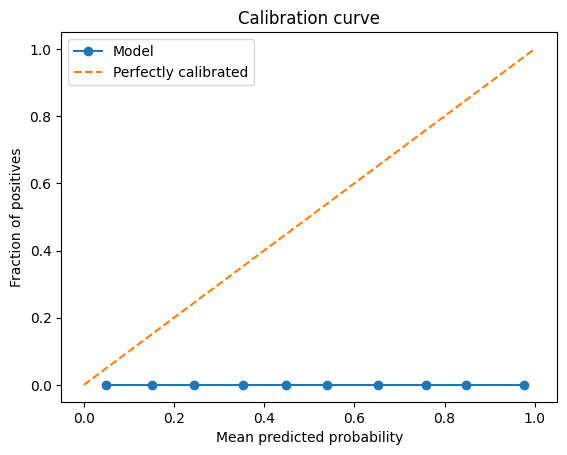

In [112]:
# Calibration curve
prob_true, prob_pred = calibration_curve( preds["True Label"], preds["Probability Score"], n_bins=10, strategy='uniform')
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve')
plt.legend()
plt.show()

In [38]:
# Gather patient data

preds['Image'] = preds['Filename'].apply(lambda x: x.split("_")[2].split(".")[0])

# Link to diagnosis data
linkdDF = pd.merge( preds,
    ds_bag_test.get_table_as_dataframe('Image_Diagnosis')[['Image','Diagnosis_Image']],
    on = 'Image', how = 'left' 
)

# Link to image data
linkdDF = pd.merge( linkdDF,
                   ds_bag_test.get_table_as_dataframe('Image')[['RID', 'Observation']],
                   left_on = 'Image', right_on = 'RID', 
                   how = 'left')
linkdDF = linkdDF.drop('RID', axis = 1)

# Link to observation data
linkdDF = pd.merge( linkdDF,
                   ds_bag_test.get_table_as_dataframe('Observation')[['RID', 'Subject']],
                   left_on = 'Observation', right_on = 'RID', 
                   how = 'left')
linkdDF = linkdDF.drop('RID', axis = 1)

linkdDF = pd.merge( linkdDF,
                   ds_bag_test.get_table_as_dataframe('Subject')[['RID', 'Subject_Gender', 'Subject_Ethnicity']],
                   left_on = 'Subject', right_on = 'RID', 
                   how = 'left')
linkdDF = linkdDF.drop('RID', axis = 1)

linkdDF['Subject_Ethnicity'] = linkdDF['Subject_Ethnicity'].astype('category')


In [46]:
linkdDF['Subject_Gender'].value_counts()/656, linkdDF['Subject_Ethnicity'].value_counts()/656

(Subject_Gender
 M    0.603659
 F    0.373476
 N    0.022866
 Name: count, dtype: float64,
 Subject_Ethnicity
 Asian                      0.256098
 African Descent            0.228659
 ethnicity not specified    0.179878
 Other                      0.178354
 Caucasian                  0.157012
 Name: count, dtype: float64)

In [56]:
# Explore performance metrics

# Confirm AUC
fpr, tpr, thresholds = roc_curve( preds["True Label"], preds["Probability Score"])
print( "Overall AUC" )
print( auc(fpr, tpr) )

# Check AUC by ethnicity
for e in pd.unique( linkdDF['Subject_Ethnicity'] ):
    tDF = linkdDF[ linkdDF['Subject_Ethnicity'] == e ]
    fpr, tpr, thresholds = roc_curve( tDF["True Label"], tDF["Probability Score"])
    print( e )
    print( auc(fpr, tpr) )

# Check AUC by gender
for g in pd.unique( linkdDF['Subject_Gender'] ):
    tDF = linkdDF[ linkdDF['Subject_Gender'] == g ]
    fpr, tpr, thresholds = roc_curve( tDF["True Label"], tDF["Probability Score"])
    print( g )
    print( auc(fpr, tpr) )

Overall AUC
0.8177326149465398
African Descent
0.8128561253561254
Caucasian
0.7978080120937265
Other
0.8331385154880186
ethnicity not specified
0.7979885057471264
Asian
0.8468749999999999
M
0.8109370215372053
F
0.8286554397219995
N
0.8392857142857143


In [62]:
linkdDF[ (linkdDF[ 'Diagnosis_Image' ] == 'Suspected Glaucoma') & (linkdDF[ 'Prediction' ] == 0) ]

,Filename,True Label,Prediction,Probability Score,Image,Diagnosis_Image,Observation,Subject,Subject_Gender,Subject_Ethnicity
326,Suspected_Glaucoma/Cropped_2-CXM8.JPG,1.0,0,0.192375,2-CXM8,Suspected Glaucoma,2-CNB0,2-CMXR,N,ethnicity not specified
329,Suspected_Glaucoma/Cropped_2-CXT8.JPG,1.0,0,0.476227,2-CXT8,Suspected Glaucoma,2-CNC0,2-CK7Y,M,Asian
330,Suspected_Glaucoma/Cropped_2-CXTC.JPG,1.0,0,0.052002,2-CXTC,Suspected Glaucoma,2-CNC0,2-CK7Y,M,Asian
347,Suspected_Glaucoma/Cropped_2-CY9C.JPG,1.0,0,0.491940,2-CY9C,Suspected Glaucoma,2-CNEJ,2-CJ7C,M,Other
355,Suspected_Glaucoma/Cropped_2-CYEC.JPG,1.0,0,0.451641,2-CYEC,Suspected Glaucoma,2-CNFC,2-CK3E,M,Other
412,Suspected_Glaucoma/Cropped_2-D0GM.JPG,1.0,0,0.065349,2-D0GM,Suspected Glaucoma,2-CNTG,2-CK36,M,Other
413,Suspected_Glaucoma/Cropped_2-D0GP.JPG,1.0,0,0.098549,2-D0GP,Suspected Glaucoma,2-CNTG,2-CK36,M,Other
435,Suspected_Glaucoma/Cropped_2-D1FT.JPG,1.0,0,0.426740,2-D1FT,Suspected Glaucoma,2-CNZP,2-CFXJ,M,Caucasian
440,Suspected_Glaucoma/Cropped_2-D1RW.JPG,1.0,0,0.300748,2-D1RW,Suspected Glaucoma,2-CP18,2-CG4P,M,Caucasian
446,Suspected_Glaucoma/Cropped_2-D27M.JPG,1.0,0,0.144418,2-D27M,Suspected Glaucoma,2-CP3M,2-CN9A,F,African Descent


# Upload Results

In [118]:
# # crete asset path
# asset_type_name = "Diagnosis_Analysis"
# asset_path = exec.execution_asset_path(asset_type_name)

# # save assets to asset_path
# linkdDF.to_csv(asset_path/'ImagesToVGG19.csv', index=False)

# upload assets to catalog
exec.upload_execution_outputs(clean_folder=True)

2025-03-24 16:16:09,766 - INFO - Initializing uploader: GenericUploader v1.7.6 [Python 3.10.13, Linux-5.10.210-201.852.amzn2.x86_64-x86_64-with-glibc2.26]
2025-03-24 16:16:09,767 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2025-03-24 16:16:09,767 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2025-03-24 16:16:09,804 - INFO - Scanning files in directory [/home/kb_766/deriva-ml/DerivaML_working/deriva-ml/execution/4-S42C]...
2025-03-24 16:16:09,805 - INFO - Including file: [/home/kb_766/deriva-ml/DerivaML_working/deriva-ml/execution/4-S42C/execution-metadata/Execution_Config/configuration.json].
2025-03-24 16:16:09,806 - INFO - Including file: [/home/kb_766/deriva-ml/DerivaML_working/deriva-ml/execution/4-S42C/execution-metadata/Runtime_Env/environment_snapshot_ytvbrm53.txt].
2025-03-24

{'Execution_Config/configuration.json': FileUploadState(state=<UploadState.success: 0>, status='Complete', result={'URL': '/hatrac/execution_metadata/c574c9dbd4d2f1c98a1120b20c9c2b3a.configuration.json:dzyDIqTmdshSDmojKAIzT8JYnBDH1Mdx', 'RID': '4-S4R0', 'RCT': '2025-03-24T23:16:10.356903+00:00', 'RMT': '2025-03-24T23:16:10.356903+00:00', 'RCB': 'https://auth.globus.org/6022643c-876c-4a47-bafa-5b9fac2c7782', 'RMB': 'https://auth.globus.org/6022643c-876c-4a47-bafa-5b9fac2c7782', 'Filename': 'configuration.json', 'Description': None, 'Length': 226, 'MD5': 'c574c9dbd4d2f1c98a1120b20c9c2b3a', 'Execution_Metadata_Type': 'Execution_Config'}, rid='4-S4R0'),
 'Runtime_Env/environment_snapshot_ytvbrm53.txt': FileUploadState(state=<UploadState.success: 0>, status='Complete', result={'URL': '/hatrac/execution_metadata/4bdd399d7cc638e1bb0e992d330c240b.environment_snapshot_ytvbrm53.txt:yPxwkhgeO6Ub5AcWr6kVDY8hvXhRfPpx', 'RID': '4-S4R2', 'RCT': '2025-03-24T23:16:10.635156+00:00', 'RMT': '2025-03-24T2